Shown in fig 1.

In [1]:
from common import colors, sbarlw, insetlw, savefig

In [2]:
import os
os.chdir(os.path.join('..', '..'))
print(os.getcwd())

/home/efharkin/projects/raphegif/raphegif


In [3]:
from __future__ import division, print_function

import pickle
import warnings

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import seaborn as sns
from scipy import stats
from scipy.signal import find_peaks
import pandas as pd

from ezephys import pltools
from ezephys.rectools import ABFLoader
from grr.cell_class import (
    subtract_baseline,
    subtract_leak,
)
from grr.CurveFit import fit_decay_curve, fit_gating_curve, plot_linear_fit
from grr.Tools import dashedBorder, timeToIndex

In [4]:
IMG_PATH = os.getenv('IMG_PATH')
DATA_PATH = os.getenv('DATA_PATH')
NOTEBOOK_PATH = os.path.join('figs', 'scripts')

plt.style.use(os.path.join(NOTEBOOK_PATH, 'publication_figure_style.dms'))

## Load recordings

In [5]:
# Load V-steps files for sample pharma traces.
l = ABFLoader()

# Load pharmacology recordings. Comment field of index.csv contains info about
# drug condition.
pharmacol_recordings = pd.read_csv(
    os.path.join(DATA_PATH, 'raw', '5HT', 'pharmacology', 'index.csv')
)
pharmacol = {
    row['comment']: l.load(
        [
            os.path.join(
                DATA_PATH, 'raw', '5HT', 'pharmacology', row['filename']
            )
        ]
    )[0]
    for _, row in pharmacol_recordings.iterrows()
}
print('Available drug conditions: {}'.format(pharmacol.keys()))

# Load voltage step recordings for characterizing voltage dependence of gating.
gating_recordings = pd.read_csv(
    os.path.join(DATA_PATH, 'raw', '5HT', 'gating', 'index.csv')
)
for access_cutoff in [20, 30]:
    included_cells = gating_recordings.query(
        'include and access_resistance_megaohm <= @access_cutoff'
    )
    print(
        '{} of {} cells with access resistance <= {} MOhm '
        '(Ra = {:.1f} MOhm +/- {:.1f} MOhm, mean +/- SD)'.format(
            included_cells.shape[0],
            gating_recordings['include'].sum(),
            access_cutoff,
            included_cells['access_resistance_megaohm'].mean(),
            included_cells['access_resistance_megaohm'].std(),
        ),
    )

# Only use recordings with access resistance below 20.
gating = l.load(
    [
        os.path.join(DATA_PATH, 'raw', '5HT', 'gating', filename)
        for filename in gating_recordings.query(
            'include and access_resistance_megaohm <= 20'
        )['filename']
    ]
)

the default signal_group_mode will change from 'split-all' to 'group-by-same-units' in next release
the default signal_group_mode will change from 'split-all' to 'group-by-same-units' in next release
the default signal_group_mode will change from 'split-all' to 'group-by-same-units' in next release
the default signal_group_mode will change from 'split-all' to 'group-by-same-units' in next release
the default signal_group_mode will change from 'split-all' to 'group-by-same-units' in next release


Available drug conditions: ['TEA', 'baseline', 'TEA + 4-AP']
10 of 13 cells with access resistance <= 20 MOhm (Ra = 12.1 MOhm +/- 4.0 MOhm, mean +/- SD)
13 of 13 cells with access resistance <= 30 MOhm (Ra = 14.7 MOhm +/- 6.2 MOhm, mean +/- SD)


the default signal_group_mode will change from 'split-all' to 'group-by-same-units' in next release
the default signal_group_mode will change from 'split-all' to 'group-by-same-units' in next release
the default signal_group_mode will change from 'split-all' to 'group-by-same-units' in next release
the default signal_group_mode will change from 'split-all' to 'group-by-same-units' in next release
the default signal_group_mode will change from 'split-all' to 'group-by-same-units' in next release
the default signal_group_mode will change from 'split-all' to 'group-by-same-units' in next release
the default signal_group_mode will change from 'split-all' to 'group-by-same-units' in next release
the default signal_group_mode will change from 'split-all' to 'group-by-same-units' in next release


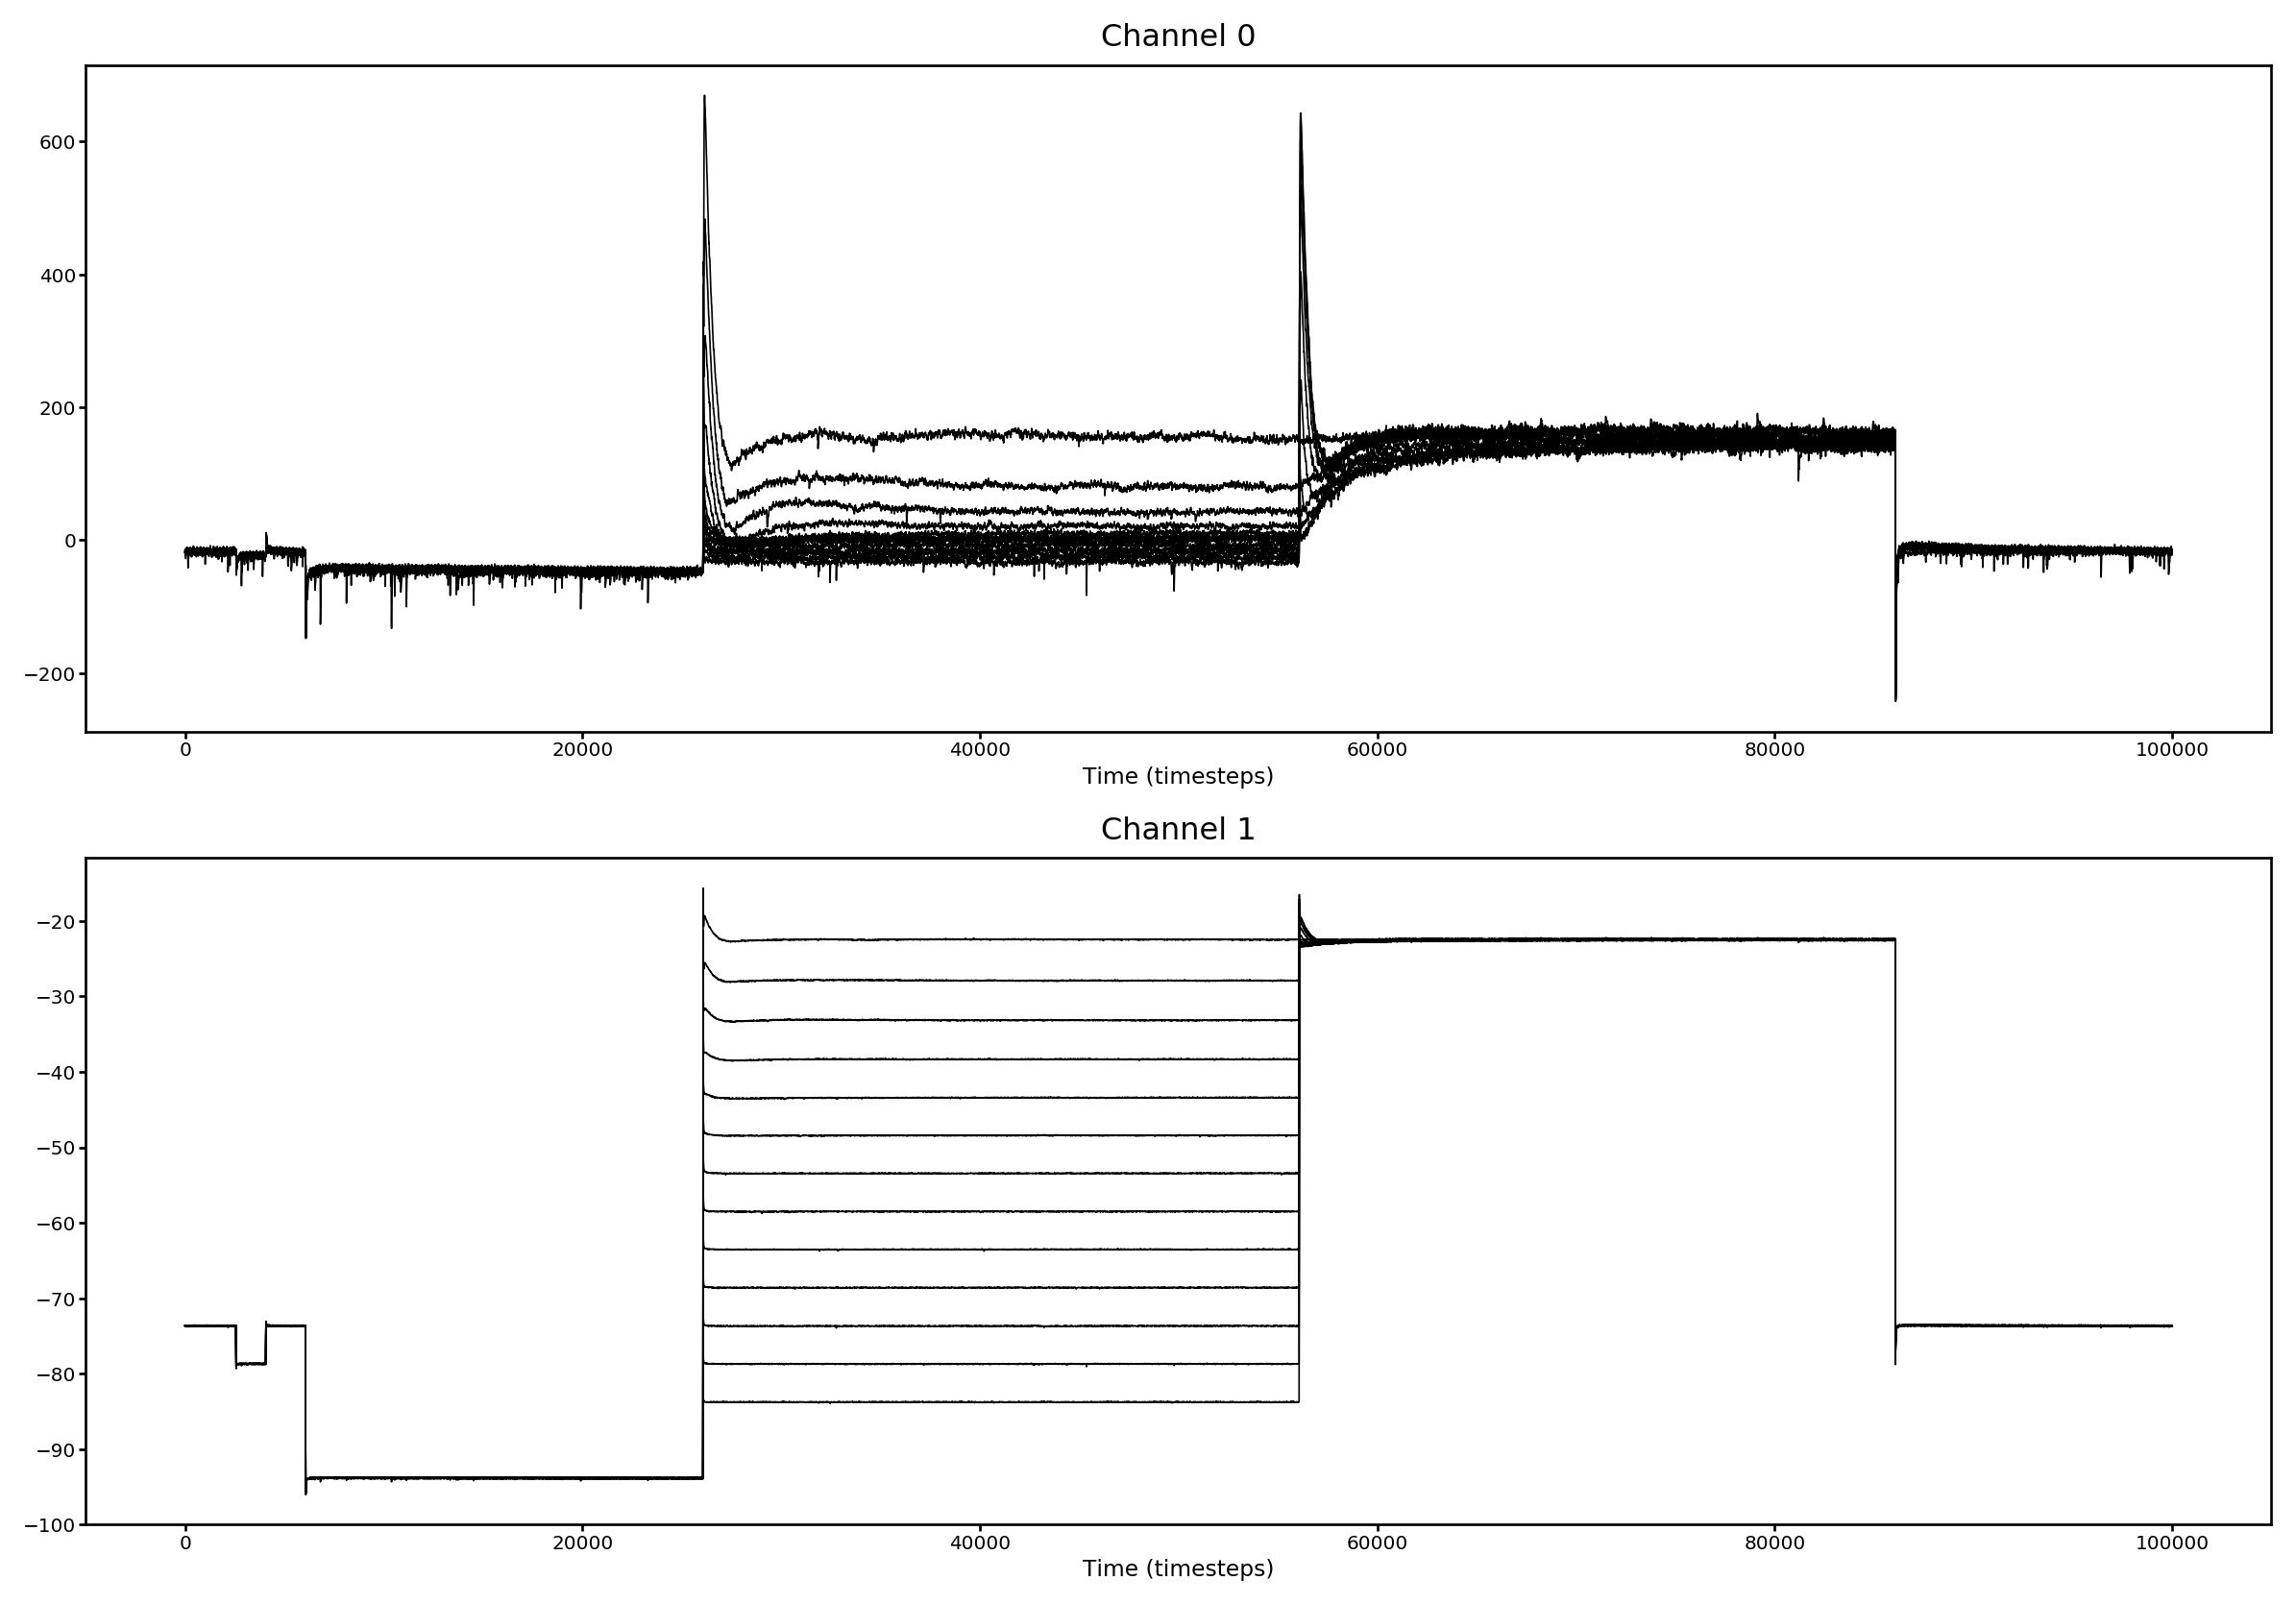

Command voltages in mV for each sweep
Baseline: [-73.63891602 -73.66943359 -73.60839844 -73.63891602 -73.66943359
 -73.60839844 -73.66943359 -73.63891602 -73.60839844 -73.66943359
 -73.66943359 -73.63891602 -73.60839844]
De-inactivating pre-pulse: [-93.84155273 -93.90258789 -93.90258789 -93.90258789 -93.90258789
 -93.84155273 -93.81103516 -93.84155273 -93.81103516 -93.84155273
 -93.90258789 -93.84155273 -93.78051758]
Activation step: [-83.77075195 -78.76586914 -73.69995117 -68.60351562 -63.53759766
 -58.50219727 -53.4362793  -48.37036133 -43.42651367 -38.33007812
 -33.203125   -27.89306641 -22.4609375 ]


In [6]:
gating[0].plot()
CURRENT_CHANNEL, VOLTAGE_CHANNEL = 0, 1

print('Command voltages in mV for each sweep')
print('Baseline: {}'.format(gating[0][1, 0, :]))
print('De-inactivating pre-pulse: {}'.format(gating[0][1, 20000, :]))
print('Activation step: {}'.format(gating[0][1, 40000, :]))

## Subtract baseline/leak

In [7]:
def preprocess_recording(recording):
    """Dirty helper function for baseline and leak current subtraction."""
    baseline_slice = slice(1000, 2000)
    test_pulse_slice = slice(3000, 3400)

    baseline_subtracted = subtract_baseline(
        recording, baseline_slice, CURRENT_CHANNEL
    )
    fully_processed = subtract_leak(
        baseline_subtracted,
        baseline_slice,
        test_pulse_slice,
        VOLTAGE_CHANNEL,
        CURRENT_CHANNEL,
    )
    return fully_processed

pharmacol = {k: preprocess_recording(r) for k, r in pharmacol.items()}
gating = [preprocess_recording(r) for r in gating]

## Fit decay

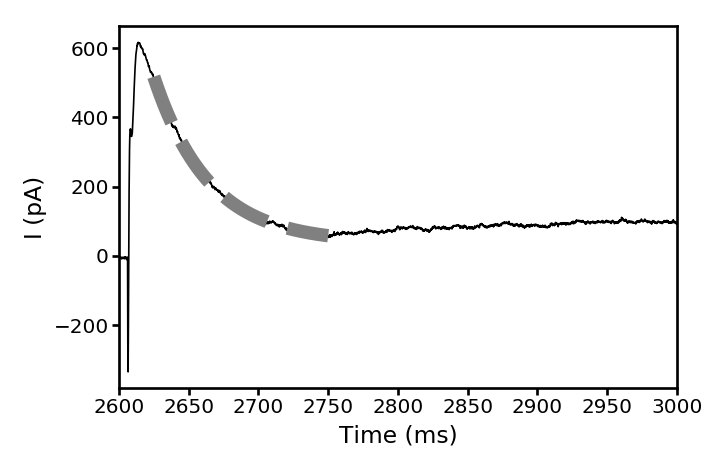

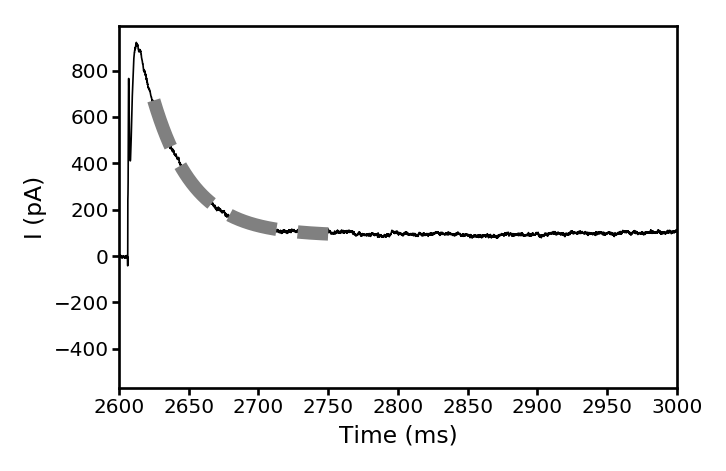

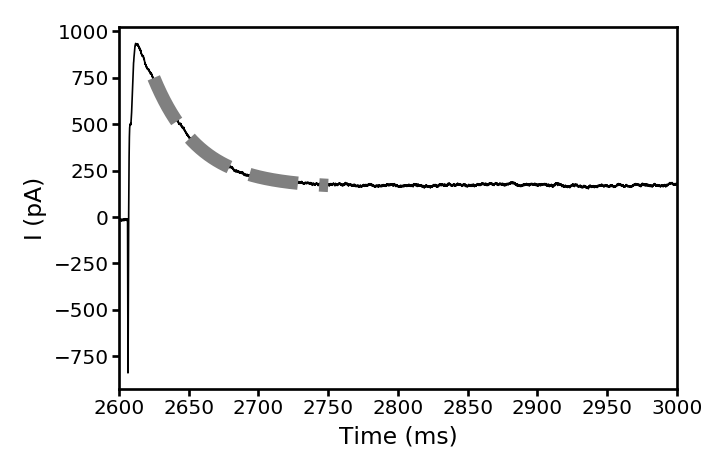

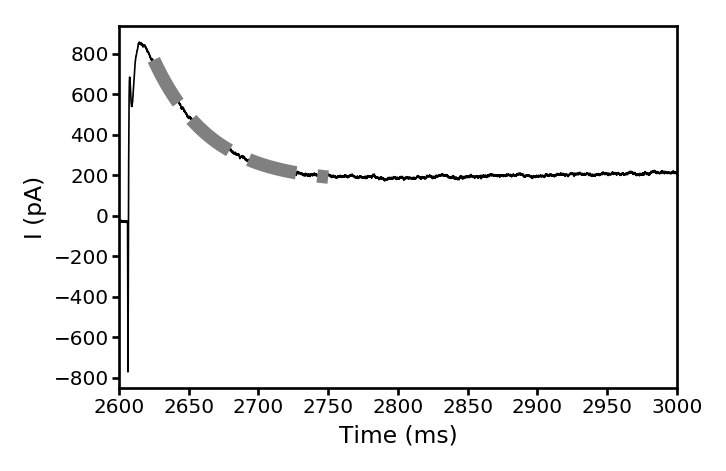

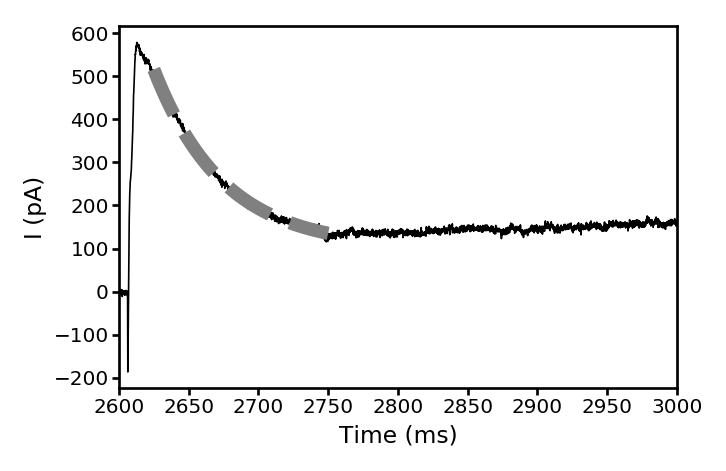

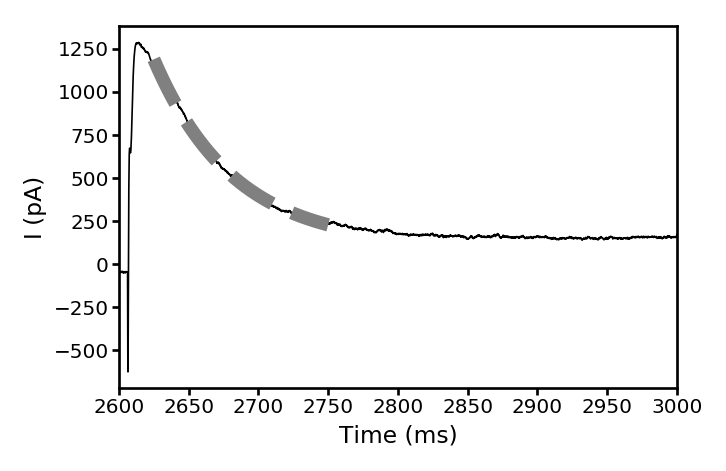

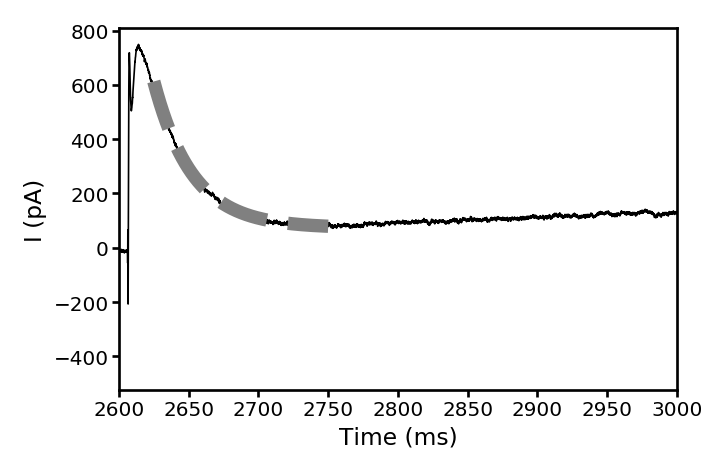

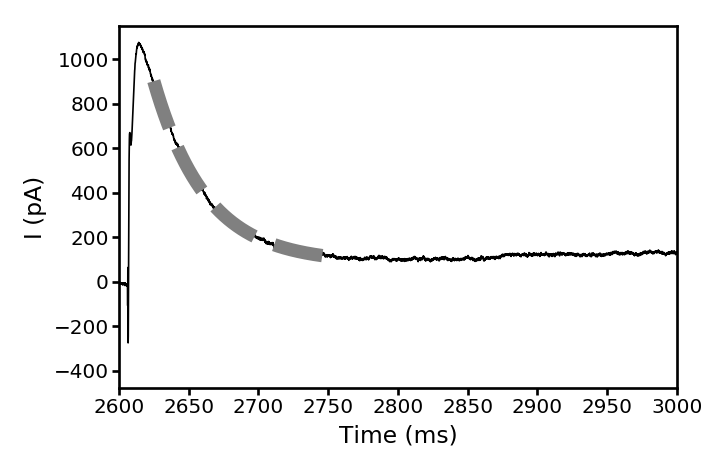

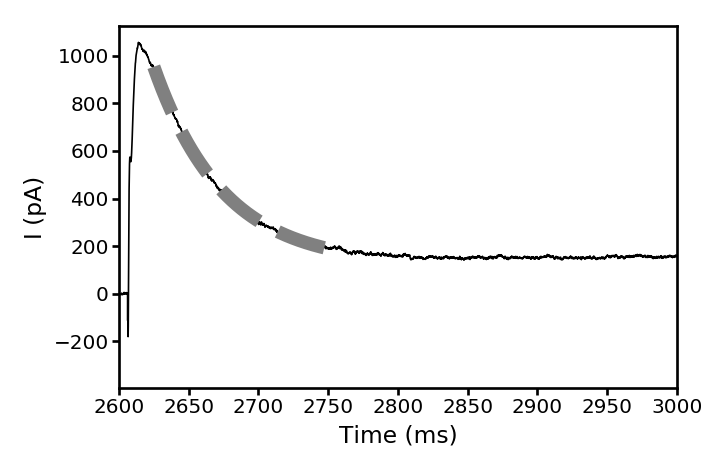

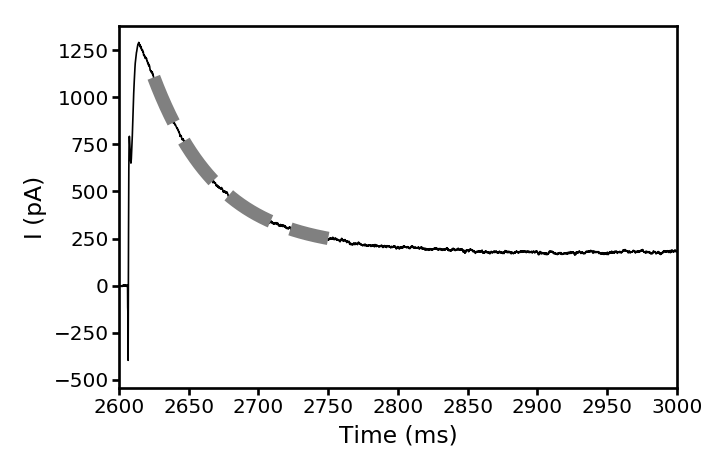

IA inactivation tau 41.0 +/- 9.3 (mean +/- SD)


In [8]:
STEP_AMPLITUDE = 50  # 70mV (-70 to -20)

IA_inactivation = {
    'traces': [],
    'fitted_data': [],
    'fitted_curves': [],
    'range_fitted': [],
    'inactivation_taus': [],
    'peak_latencies': [],
    'peak_amplitudes': [],
    'steady_state_amplitudes': [],
    'peak_exists': [],
}

peak_fit_params = {
    'stimulus_start_time': 2606.2,
    'steady_state_time': 3606.2,
    'peak_slice': slice(26085, 30000),
    'decay_slice': slice(26250, 27500),
}

for i, rec in enumerate(gating):
    # Determine whether there is a peak using same method as for GABA.
    peak_inds = find_peaks(
        rec[0, peak_fit_params['peak_slice'], -1],
        distance=500,
        prominence=50.0,
        width=100,
    )[0]
    IA_inactivation['peak_exists'].append(len(peak_inds) > 0)
    if len(peak_inds) > 1:
        warnings.warn(
            '{} peaks detected for recording {}.'.format(len(peak_inds), i)
        )

    # Find peak latency
    IA_inactivation['peak_latencies'].append(
        np.argmax(rec[0, peak_fit_params['peak_slice'], -1]) * 0.1
        + peak_fit_params['peak_slice'].start * 0.1
        - peak_fit_params['stimulus_start_time']
    )

    # Get peak amplitude.
    IA_inactivation['peak_amplitudes'].append(
        rec[
            0,
            np.argmax(rec[0, peak_fit_params['peak_slice'], -1])
            + peak_fit_params['peak_slice'].start,
            -1,
        ]
    )

    # Get steady-state amplitude
    IA_inactivation['steady_state_amplitudes'].append(
        rec[0, timeToIndex(peak_fit_params['steady_state_time'], 0.1)[0], -1]
    )

    # Fit decay
    IA_inactivation['range_fitted'].append(
        [
            peak_fit_params['decay_slice'].start * 0.1,
            peak_fit_params['decay_slice'].stop * 0.1,
        ]
    )

    t_vec = np.arange(0, rec.shape[1], 0.1)[: rec.shape[1]]
    fitted_tmp = rec[0, peak_fit_params['decay_slice'], -1]
    IA_inactivation['fitted_data'].append(
        np.array([fitted_tmp, t_vec[peak_fit_params['decay_slice']]])
    )

    IA_inactivation['traces'].append(
        np.array([rec[0, :, -1], rec[1, :, -1], t_vec])
    )

    p_tmp, fitted_tmp = fit_decay_curve(
        fitted_tmp,
        [fitted_tmp[0] - fitted_tmp[-1], fitted_tmp[-1], 20],
        dt=0.1,
    )

    IA_inactivation['inactivation_taus'].append(p_tmp[2])
    IA_inactivation['fitted_curves'].append(
        np.array(
            [
                fitted_tmp[0, :],
                np.linspace(
                    peak_fit_params['decay_slice'].start * 0.1,
                    peak_fit_params['decay_slice'].stop * 0.1,
                    len(fitted_tmp[0, :]),
                ),
            ]
        )
    )

    # Diagnostic plot of decay fit.
    plt.figure()
    plt.plot(t_vec, rec[0, :, -1], 'k-', lw=0.5)
    plt.plot(
        np.linspace(
            peak_fit_params['decay_slice'].start * 0.1,
            peak_fit_params['decay_slice'].stop * 0.1,
            len(fitted_tmp[0, :]),
        ),
        fitted_tmp[0, :],
        '--',
        color='gray',
        lw=4,
    )
    plt.ylabel('I (pA)')
    plt.xlabel('Time (ms)')
    plt.xlim(2600, 3000)
    plt.show()


IA_inactivation = {k: np.array(v) for k, v in IA_inactivation.items()}
print(
    'IA inactivation tau {:.1f} +/- {:.1f} (mean +/- SD)'.format(
        IA_inactivation['inactivation_taus'].mean(),
        IA_inactivation['inactivation_taus'].std(),
    )
)

#with open(PROCESSED_PATH + 'inactivation_fits.dat', 'wb') as f:
#    pickle.dump(IA_inactivation, f)

In [9]:
IA_inactivation.keys()

['traces',
 'fitted_data',
 'steady_state_amplitudes',
 'inactivation_taus',
 'peak_amplitudes',
 'peak_exists',
 'fitted_curves',
 'peak_latencies',
 'range_fitted']

In [10]:
for dataset in [
    'peak_amplitudes',
    'peak_latencies',
    'steady_state_amplitudes',
    'inactivation_taus',
]:
    print(
        '{:>25} {:>10.3} +/- {:>5.3}'.format(
            dataset,
            np.mean(IA_inactivation[dataset]),
            stats.sem(IA_inactivation[dataset]),
        )
    )

          peak_amplitudes   9.37e+02 +/-  78.6
           peak_latencies       7.42 +/- 0.271
  steady_state_amplitudes   1.59e+02 +/-  11.3
        inactivation_taus       41.0 +/-   3.1


## Summary statistics for quantities in nS

In [11]:
print('Peak amplitudes (nS) {:>20.3} +/- {:>5.3}'.format(
    np.mean(IA_inactivation['peak_amplitudes'] / STEP_AMPLITUDE),
    stats.sem(IA_inactivation['peak_amplitudes'] / STEP_AMPLITUDE)
))
print('Steady state amplitudes (nS) {:>20.3} +/- {:>5.3}'.format(
    np.mean(IA_inactivation['steady_state_amplitudes'] / STEP_AMPLITUDE),
    stats.sem(IA_inactivation['steady_state_amplitudes'] / STEP_AMPLITUDE)
))

Peak amplitudes (nS)                 18.7 +/-  1.57
Steady state amplitudes (nS)                 3.17 +/- 0.226


## Table of extracted parameters

In [12]:
IA_inactivation['steady_state_conductance'] = (
    IA_inactivation['steady_state_amplitudes'] / STEP_AMPLITUDE
)
IA_inactivation['peak_conductance'] = (
    IA_inactivation['peak_amplitudes'] / STEP_AMPLITUDE
)

In [13]:
statistics = [
    'peak_latencies',
    'steady_state_amplitudes',
    'steady_state_conductance',
    'peak_conductance',
    'peak_amplitudes',
    'inactivation_taus',
    'peak_exists',
]
stats_df = pd.DataFrame({key: IA_inactivation[key] for key in statistics})

In [14]:
stats_df

,inactivation_taus,peak_amplitudes,peak_conductance,peak_exists,peak_latencies,steady_state_amplitudes,steady_state_conductance
0,39.280178,616.019392,12.320388,True,7.7,97.607349,1.952147
1,28.866688,921.168675,18.423373,True,6.3,107.386440,2.147729
2,32.445161,935.471419,18.709428,True,5.8,170.499481,3.409990
3,40.782865,855.081312,17.101626,True,8.3,220.519097,4.410382
4,49.629096,578.376225,11.567524,True,6.6,166.533216,3.330664
5,57.185124,1287.397250,25.747945,True,7.9,155.052318,3.101046
6,27.602526,749.077922,14.981558,True,7.8,151.887616,3.037752
7,37.392290,1076.172008,21.523440,True,8.0,160.327488,3.206550
8,49.753422,1055.642518,21.112850,True,7.8,167.120445,3.342409
9,46.934444,1291.528419,25.830568,True,8.0,190.159522,3.803190


In [15]:
stats_df.mean()

inactivation_taus            40.987179
peak_amplitudes             936.593514
peak_conductance             18.731870
peak_exists                   1.000000
peak_latencies                7.420000
steady_state_amplitudes     158.709297
steady_state_conductance      3.174186
dtype: float64

In [16]:
stats_df.std()

inactivation_taus             9.798941
peak_amplitudes             248.513309
peak_conductance              4.970266
peak_exists                   0.000000
peak_latencies                0.856089
steady_state_amplitudes      35.762408
steady_state_conductance      0.715248
dtype: float64

In [17]:
stats_df.sem()

inactivation_taus            3.098697
peak_amplitudes             78.586809
peak_conductance             1.571736
peak_exists                  0.000000
peak_latencies               0.270719
steady_state_amplitudes     11.309066
steady_state_conductance     0.226181
dtype: float64

Save to CSV.

In [18]:
stats_df.to_csv(
    os.path.join(
        DATA_PATH, 'processed', '5HT', 'transient_current_parameters.csv'
    ),
    index=False,
)

# Figures

/home/efharkin/.miniconda3/envs/raphegif/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


Saving svg
Saving png
Done!


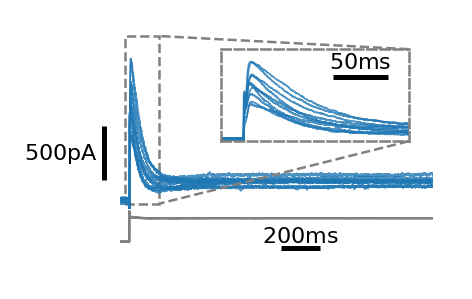

In [19]:
FIT_EXAMPLE_NO = 5
BG_TR_ALPHA = 0.8

tr_spec = gs.GridSpec(
    2,
    1,
    height_ratios=[1, 0.2],
    hspace=0,
    top=0.97,
    bottom=0.05,
    right=0.97,
    left=0.1,
)

plt.figure(figsize=(1.5, 1))

wc_ax = plt.subplot(tr_spec[0, :])
plt.plot(
    (IA_inactivation['traces'][:, 2, :].T - 2606.2),
    IA_inactivation['traces'][:, 0, :].T,
    '-',
    color=colors['ser'],
    lw=0.5,
    alpha=BG_TR_ALPHA,
)
plt.xlim(-50, 1550)
plt.ylim(-100, 1600)
pltools.add_scalebar(
    y_units='pA', omit_x=True, anchor=(-0.05, 0.1), linewidth=sbarlw
)
sns.despine(ax=plt.gca(), trim=True)

wc_ins = inset_axes(wc_ax, '60%', '50%', loc='upper right', borderpad=1.2)
plt.plot(
    (IA_inactivation['traces'][:, 2, :].T - 2606.2),
    IA_inactivation['traces'][:, 0, :].T,
    '-',
    color=colors['ser'],
    lw=0.5,
    alpha=BG_TR_ALPHA,
)
plt.xlim(-20, 150)
plt.ylim(-50, 1500)
pltools.add_scalebar(
    x_units='ms',
    omit_y=True,
    anchor=(0.95, 0.7),
    x_label_space=0.05,
    remove_frame=False,
    linewidth=sbarlw,
)
plt.xticks([])
plt.yticks([])
dashedBorder(wc_ins, lw=insetlw)
mark_inset(wc_ax, wc_ins, 1, 4, ls='--', color='gray', lw=insetlw)

plt.subplot(tr_spec[1, :])
plt.plot(
    (IA_inactivation['traces'][:, 2, :].T - 2606.2),
    IA_inactivation['traces'][:, 1, :].T,
    '-',
    color=colors['input'],
    lw=0.5,
    alpha=BG_TR_ALPHA,
)
plt.xlim(-50, 1550)
pltools.add_scalebar(
    x_units='ms',
    x_size=200,
    omit_y=True,
    anchor=(0.7, -0.05),
    x_label_space=0.05,
    linewidth=sbarlw,
)

plt.tight_layout()

if IMG_PATH is not None:
    savefig(os.path.join(IMG_PATH, 'ser_kinetics_trace_only'))

plt.show()

Saving svg
Saving png
Done!


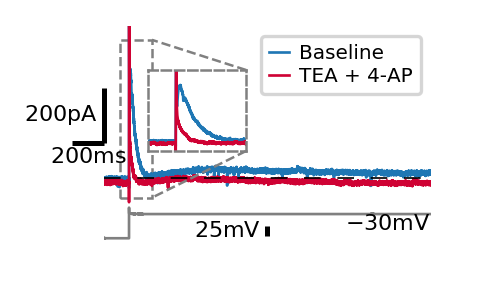

In [20]:
Kslow_xlim = (2450, 8500)

spec_pharm = gs.GridSpec(
    2,
    1,
    height_ratios=[1, 0.2],
    hspace=0,
    left=0.15,
    bottom=0.05,
    top=0.95,
    right=0.95,
)

PHARM_SWEEP = -3

plt.figure(figsize=(1.7, 1))

pharm_ax = plt.subplot(spec_pharm[0, :])
plt.plot(
    pharmacol['baseline'].time_supp,
    pharmacol['baseline'][CURRENT_CHANNEL, :, PHARM_SWEEP],
    #linewidth=0.5,
    color=colors['ser'],
    label='Baseline',
)
plt.plot(
    pharmacol['TEA + 4-AP'].time_supp,
    pharmacol['TEA + 4-AP'][CURRENT_CHANNEL, :, PHARM_SWEEP],
    #linewidth=0.5,
    color=colors['4AP'],
    label='TEA + 4-AP',
)
plt.axhline(0, ls='--', lw=0.5, color='k', dashes=(10, 10))
plt.xlim(Kslow_xlim[0], 4500)
plt.ylim(-100, 550)
pltools.add_scalebar(
    'ms',
    'pA',
    anchor=(0, 0.35),
    y_size=200,
    x_size=200,
    bar_space=0,
    x_label_space=-0.02,
    linewidth=sbarlw,
)
plt.legend()

pharm_ins = inset_axes(pharm_ax, '30%', '45%', loc='upper left', borderpad=2.2)
plt.plot(
    pharmacol['baseline'].time_supp,
    pharmacol['baseline'][CURRENT_CHANNEL, :, PHARM_SWEEP],
    #linewidth=0.5,
    color=colors['ser'],
    label='Baseline',
)
plt.plot(
    pharmacol['TEA + 4-AP'].time_supp,
    pharmacol['TEA + 4-AP'][CURRENT_CHANNEL, :, PHARM_SWEEP],
    #linewidth=0.5,
    color=colors['4AP'],
    label='TEA + 4-AP',
)
plt.xlim(Kslow_xlim[0] + 100, Kslow_xlim[0] + 300)
plt.ylim(-70, 500)
dashedBorder(pharm_ins, lw=insetlw)
pltools.hide_ticks()
mark_inset(
    pharm_ax, pharm_ins, loc1=1, loc2=4, ls='--', color='gray', lw=insetlw
)

plt.subplot(spec_pharm[1, :])
plt.plot(
    pharmacol['baseline'].time_supp,
    pharmacol['baseline'][VOLTAGE_CHANNEL, :, PHARM_SWEEP],
    #linewidth=0.5,
    color='gray',
)
pltools.add_scalebar(
    y_units='mV', anchor=(0.5, 0.1), omit_x=True, y_size=25, linewidth=sbarlw
)
plt.text(4500, -32, '$-30$mV', ha='right', va='top', size='small')
plt.xlim(Kslow_xlim[0], 4500)

if IMG_PATH is not None:
    savefig(os.path.join(IMG_PATH, 'ser_pharmacology'))